## For Colabs

In [2]:
from getpass import getpass
import os

user = "OliverJBoom"
# password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 522 (delta 47), reused 41 (delta 18), pack-reused 446
Receiving objects: 100% (522/522), 6.68 MiB | 23.59 MiB/s, done.
Resolving deltas: 100% (285/285), done.


In [3]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Loading Packages

In [4]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


True

### Insuring that training is done on GPU if available

In [13]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Loading Data

In [0]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")
use_lg_returns = False

## Preprocessing

In [15]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
  # Lg Returns Only
  df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
  target_col = "cu_lme"
  
else:
  # Price Only
  df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
  target_col = "price_cu_lme"

# Set to False initially
PCA_used = False

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [0]:
# Visualise the plots
# visualise_universe(universe_dict)

In [17]:
df_full.head(15)
# df_full.tail(5)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240
2006-09-20,69610.0,7474.0,3.3700,18091.0,537.80,3.2450,4244.0,4.937,11.39,122.71,418.32234
2006-09-21,70170.0,7602.0,3.4220,19546.0,539.70,3.2480,4200.0,4.921,12.25,119.68,423.56908
2006-09-22,71170.0,7601.0,3.4395,20627.0,538.50,3.2470,4136.0,4.924,12.59,118.86,418.01647
2006-09-25,71130.0,7560.0,3.4475,20978.0,539.30,3.2490,4069.0,4.907,12.12,120.75,418.93144


### Normalizing the dataset

In [0]:
# Forecast length
forecast_length = 5

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = shift(data_y.ravel(), -forecast_length)[:-forecast_length]
# Check shape assert(data_X.shape[:, 0]== data_y.shape[0])

### PCA

In [35]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

Number of dimensions: 6
Explained Variance: [0.49030338 0.23270694 0.1439148  0.04789975 0.02769706 0.0219951 ] 
Explained Variance Sum: 0.9645170286882996


### Slicing Series into Windows

In [0]:
# The input size of each time series window
series_length = 250
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=0.5)

### Hyperparameters

In [0]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32
test_batch_size = 1000
# series_length = 100

n_epochs = 5

# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 128
num_layers = 2
output_dim = 1
dropout = 0.2

### Initialising the model

In [22]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim, 
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 6 
hidden_dim 128
series_length 250 
batch_size 32
output_dim 1 
num_layers 2
data_X  (415, 250, 6) 
data_y (415,)


In [27]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "LSTM_0_040.pth")
# model.to(device)

LSTM(
  (lstm): LSTM(6, 128, num_layers=2, dropout=0.1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (act): ReLU()
  (out): Linear(in_features=128, out_features=1, bias=True)
)

Epoch: 0 Train MSE: 1.16754 Val MSE: 1.83988  Time: 5.128


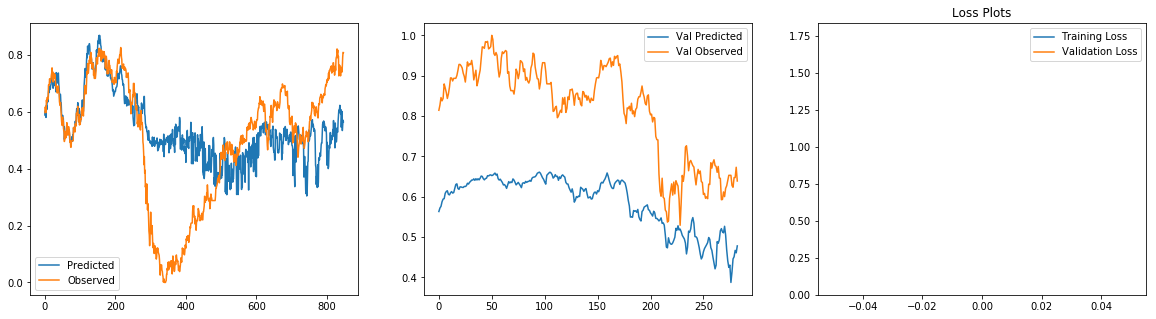

Epoch: 10 Train MSE: 0.42296 Val MSE: 1.10927  Time: 57.238
Epoch: 20 Train MSE: 0.24181 Val MSE: 1.85019  Time: 108.607


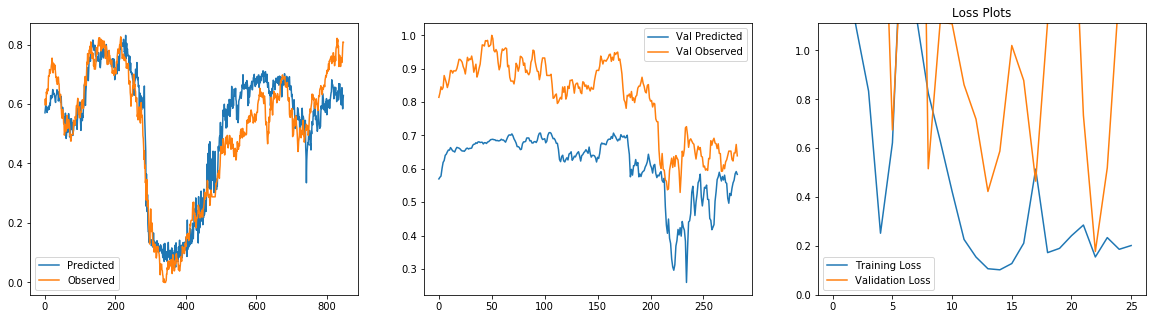

Epoch: 30 Train MSE: 0.31529 Val MSE: 0.73013  Time: 160.825
Epoch: 40 Train MSE: 0.06750 Val MSE: 0.16058  Time: 212.187
Epoch: 50 Train MSE: 0.33524 Val MSE: 1.38281  Time: 262.644


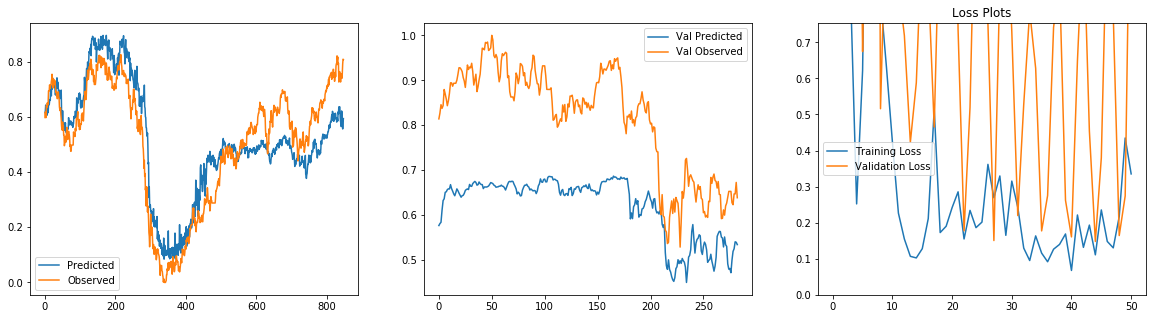

Epoch: 60 Train MSE: 0.06792 Val MSE: 0.20398  Time: 314.281
Epoch: 70 Train MSE: 0.05817 Val MSE: 0.53169  Time: 364.472


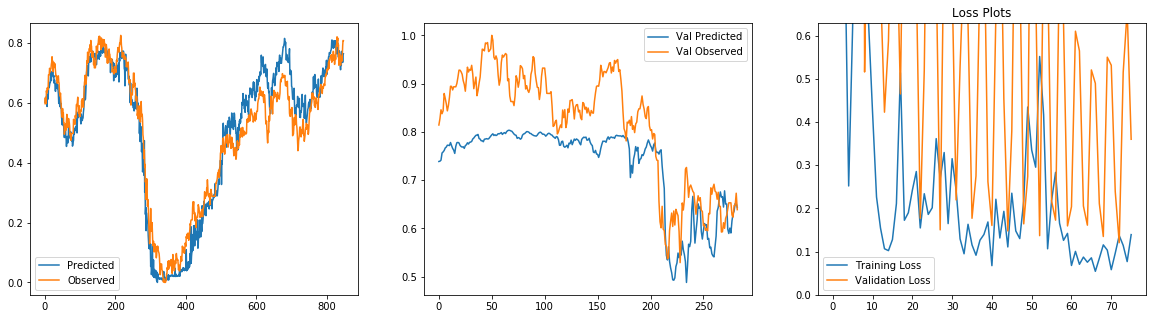

Epoch: 80 Train MSE: 0.22332 Val MSE: 0.16400  Time: 415.515
Epoch: 90 Train MSE: 0.19375 Val MSE: 0.23785  Time: 465.524
Epoch: 100 Train MSE: 0.14589 Val MSE: 1.12276  Time: 515.960


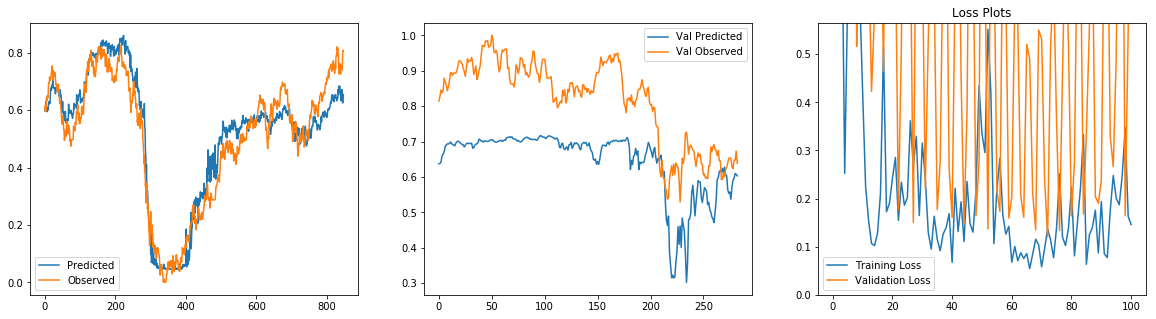

Epoch: 110 Train MSE: 0.19427 Val MSE: 0.30828  Time: 566.942
Epoch: 120 Train MSE: 0.22517 Val MSE: 1.20952  Time: 617.413


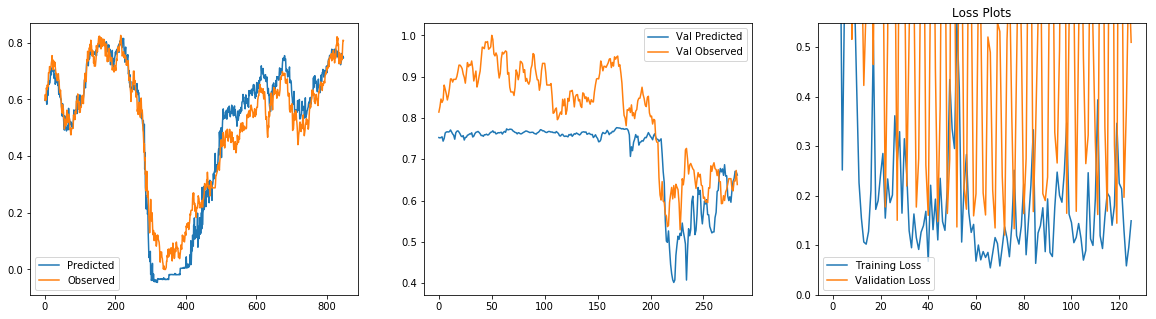

Epoch: 130 Train MSE: 0.28381 Val MSE: 0.18036  Time: 668.411
Epoch: 140 Train MSE: 0.11053 Val MSE: 0.16905  Time: 718.631
Epoch: 150 Train MSE: 1.42379 Val MSE: 0.65483  Time: 768.850


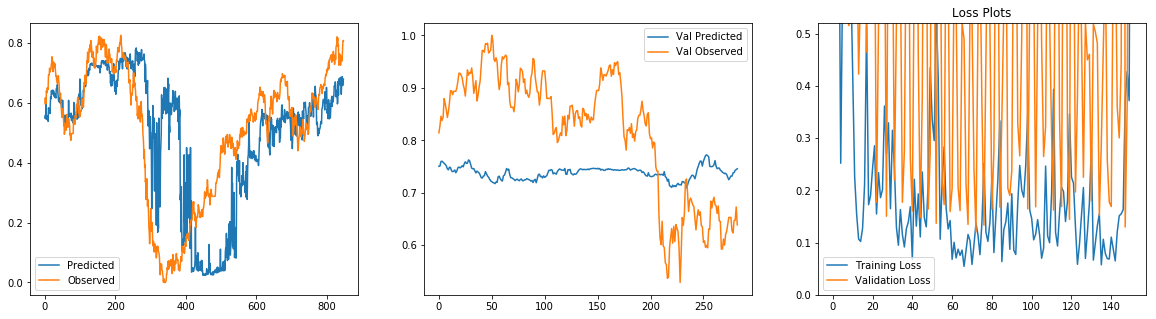

Epoch: 160 Train MSE: 0.97451 Val MSE: 3.39504  Time: 820.100
Epoch: 170 Train MSE: 0.19604 Val MSE: 0.86399  Time: 870.359


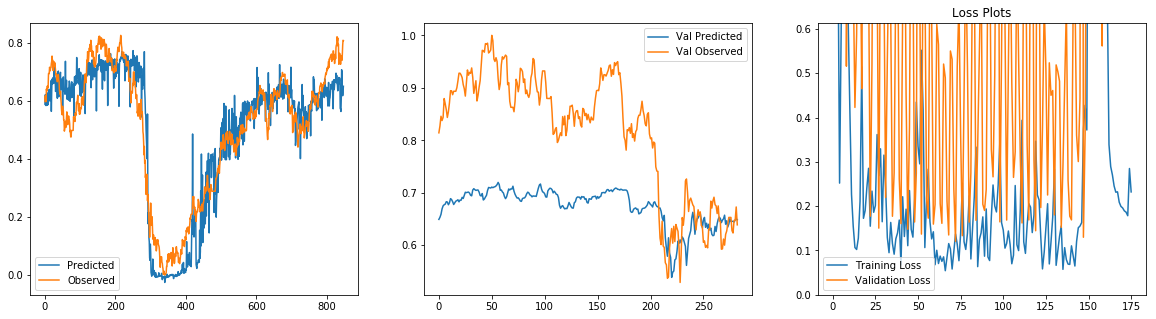

Epoch: 180 Train MSE: 0.17048 Val MSE: 0.70886  Time: 921.546
Epoch: 190 Train MSE: 0.15329 Val MSE: 0.63239  Time: 971.680
Epoch: 200 Train MSE: 0.14427 Val MSE: 0.53314  Time: 1021.947


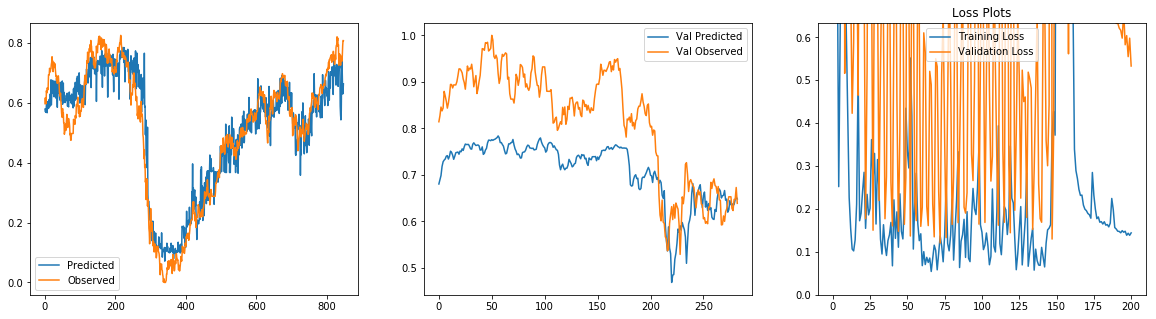

Epoch: 210 Train MSE: 0.12240 Val MSE: 0.43827  Time: 1072.936
Epoch: 220 Train MSE: 0.10742 Val MSE: 0.30452  Time: 1123.179


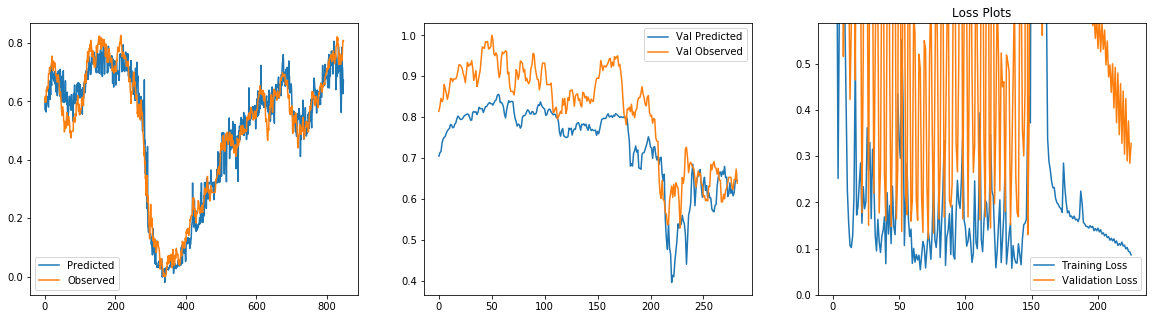

Epoch: 230 Train MSE: 0.07672 Val MSE: 0.29219  Time: 1174.097
Epoch: 240 Train MSE: 0.07190 Val MSE: 0.29502  Time: 1224.279
Epoch: 250 Train MSE: 0.08070 Val MSE: 0.34344  Time: 1274.549


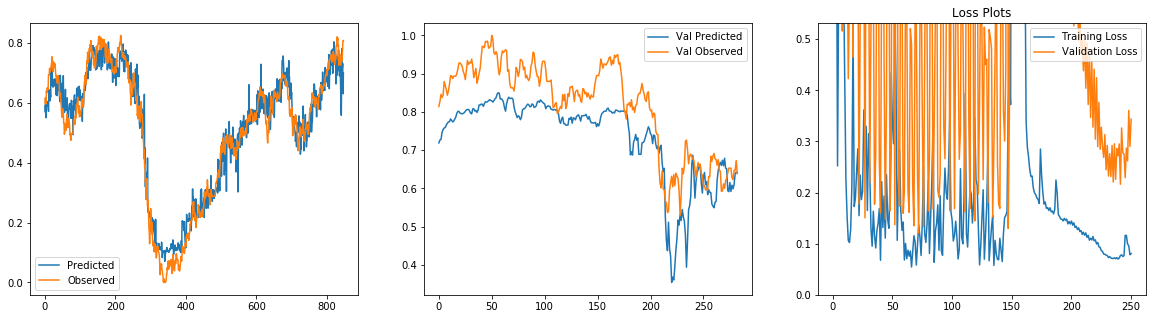

Epoch: 260 Train MSE: 0.10397 Val MSE: 0.39254  Time: 1325.451
Epoch: 270 Train MSE: 0.10199 Val MSE: 0.21974  Time: 1375.650
Early Stopping


In [38]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=10000,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=10,
                        fig_disp_freq=20, 
                        device=device,
                        patience=100)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

In [39]:
learning.best_val_score

0.12068929099362646

In [40]:
print(learning.logs["Validation Loss"])
print(learning.best_val_score)

[1.8398792482517634, 3.174256816769657, 2.0324913705616874, 1.5157897885191145, 2.136993441901864, 0.6745154545922162, 1.6347858779421964, 4.159445826661882, 0.5160108273947618, 1.1155380646668558, 1.109271005691151, 0.8597099620967367, 0.7189627418248477, 0.42292531303297926, 0.5881321952536754, 1.020348405669519, 0.8770709071479501, 0.46517265348468145, 1.1167159442766816, 1.6077761431043645, 1.850187790267459, 0.7344429400278907, 0.17742020965886202, 0.5199227788001826, 1.248205387128958, 1.4655149277865676, 0.7536644607045204, 0.1504537153581006, 0.8712420033903088, 1.105180935809132, 0.7301291610663856, 0.21972545633888918, 0.5279325621709385, 0.7870657654617363, 0.6279737865124491, 0.177207424868122, 0.27521836462795946, 0.7416006364586496, 0.8758238819378424, 0.2619163358169394, 0.160578447180165, 0.6491802084151089, 1.0180875993870173, 0.4544131612609216, 0.14793429821203116, 0.37977134212588254, 1.0829273163219222, 0.7766078369356297, 0.16430115615521218, 0.2740661958923609, 1

In [0]:
# learning.create_data_loaders()
print(learning.validate(learning.val_loader))
print(learning.evaluate(learning.best_model, learning.val_loader))

In [0]:
pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'wb'))

In [0]:
learning_load = pickle.load(open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'rb'))

In [42]:
model_save(model, 
           path="/content/gdrive/My Drive/Chai/Models/Pths",
           name="LSTM_partial_dataset", 
           val_score=learning.best_val_score)

# mod = model_load(path="Models/Pths",
#            model_name="LSTM_5_854")

Saving model: /content/gdrive/My Drive/Chai/Models/PthsLSTM_partial_dataset_0_1206.pth


### Plotting

In [0]:
# Rescaling Example

scaler_data_y.inverse_transform(np.array(learning_load.train_predictions).reshape(-1, 1))
plt.plot(scaler_data_y.inverse_transform(learning_load.y_train.numpy().reshape(-1, 1)))
plt.plot(scaler_data_y.inverse_transform(np.array(learning_load.train_predictions).reshape(-1, 1)))
plt.show()

In [0]:
predicted_train = learning.train_predictions
observed_train = learning.y_train.numpy()

learning.model = learning.best_model
learning.validate(learning.val_loader)
predicted_val = learning.val_predictions
observed_val = learning.y_val.numpy()

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Predicted vs Observed Values")
ax[0].plot(predicted_train, label="Predicted")
ax[0].plot(observed_train, label="Observed")
ax[0].legend()

ax[1].set_title("Predicted vs Observed Values")
ax[1].plot(predicted_val, label="Predicted")
ax[1].plot(observed_val, label="Observed")
ax[1].legend()
           
ax[2].set_title("Loss Plots")
ax[2].plot(learning.logs['Training Loss'], label="Training Loss")
ax[2].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[2].legend()
ax[2].set_ylim((0, 3))

epoch_reached = str(len(learning.logs['Training Loss']))
path="/content/gdrive/My Drive/Chai/Models/"

plt.savefig(path + str("LSTM_Val_" + str(val_score)[:5].replace(".", "_") + "_Epoch_" + epoch_reached + ".png"))
plt.show()

In [0]:
plt.title("Predicted vs Observed Values")
plt.plot(learning.test_predictions, label="Predicted")
plt.plot(learning.y_test.numpy(), label="Observed")
plt.legend()

In [0]:
# The minimum validation loss
val_loss = min(learning.logs['Validation Loss'])
best_model_epoch = learning.logs['Validation Loss'].index(val_loss)
train_loss = learning.logs['Training Loss'][best_model_epoch]
test_loss = learning.evaluate(learning.best_model, learning.test_loader)

In [0]:
num_epoch = 250
train_time = learning.logs["Time"]
full_save(learning.best_model, 
          "Full_Run",
          optimiser,
          num_epoch, 
          learning_rate, 
          momentum,
          weight_decay, 
          PCA_used, 
          data_X,
          train_loss,
          val_loss, 
          test_loss,
          train_time, 
          hidden_dim,
          path="/content/gdrive/My Drive/Chai/Models/") 

# Results

In [0]:
mse, mae, mde = evaluate(learning.test_predictions, learning.y_test.numpy())
print(mse, mae, mde)

## Persistance

In [0]:
plt.title("Persistance vs Observed Values")
plt.plot(learning.train_predictions, label="Predicted")
plt.plot(shift(learning.train_predictions, 5), label="Observed")
plt.legend()

In [0]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [0]:
print(df[:5])
print(df[-5:])

In [0]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()